## data loader

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
import os
import re
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2
import math


class Data_loader(tf.keras.utils.Sequence):
    
    # img_size può essere None oppure (W,H),
    def __init__(self, batch_size, imgs_path, gt_path, img_size = None, apply_augmentation = False):

        self.batch_size = batch_size
        self.imgs_path = imgs_path
        self.gt_path = gt_path
        self.img_size = img_size


        # se questo flag é false l'immagine viene solo riscalat
        self.apply_augmentation = apply_augmentation

        # carico la lista dei nomi delle immagini nel percorso passato
        regex_img = r".*\.(png|jpg)$"
        self.list_imgs = [f for f in os.listdir(imgs_path) if re.search(regex_img,f)]

        random.seed(100)
        random.shuffle(self.list_imgs)

        # leggo il file del groundtruth e creo una mappa: nome_immagine -> direzione luce
        with open(self.gt_path) as f:
            lines = f.readlines()
        
        self.gt = {}
        for line in lines[2:]:
            tokens = line.split(";")
            name = tokens[0]
            theta = float(tokens[1])
            phi = float(tokens[2])
            Ly = math.sin(phi)
            Lx = math.cos(phi) * math.cos(theta)
            Lz = math.cos(phi) * math.sin(theta)

            self.gt[name] = [Lx,Ly,Lz]
            

        print("n. imgs: {}".format(len(self.list_imgs)))


        # per la data augmentation
        self.img_augmenter = ImageDataGenerator(
                samplewise_center=True,
                samplewise_std_normalization=True,
                rescale=1./255,
                #shear_range=0.5,
                #zoom_range=0.1,
                #rotation_range=60,
                rotation_range=0,
                width_shift_range=0,
                height_shift_range=0,
                horizontal_flip=True,
                #vertical_flip=True,
                vertical_flip=False,
                fill_mode = 'wrap'
                )


        self.rescaler = ImageDataGenerator(
                rescale=1./255,
                #samplewise_center=True,
                
                #samplewise_std_normalization=True
                )

    
    def N_samples(self):
        return len(self.list_imgs)


    def shuffle(self):
        random.shuffle(self.list_imgs)

    def get_gt(self):
        return self.gt


    def __len__(self):
        return len(self.list_imgs) // self.batch_size

    def my_horiz_flip(self, img):
        return img[:,::-1,:]
    

    # ********************************************************************************************************
    # - se img_size � None e do_train_val � False il batch avr� dimensione: (batch_size, None), perch� ogni
    #      immagine avr� la sua dimensione
    # - se img_size � None e do_train_val � True allora viene effettuato un padding delle immagini in modo che il
    #      batch sia un tensore con una dimensione fissa: (batch_size, max_H, max_W, depth), dove max_H � il numero max
    #      di righe tra tutte le immagini del batch, analogo per max_W.
    # ********************************************************************************************************
    def get_batch(self, idx, img_size = None, augment = False, do_train_val = True):
        
        start = idx * self.batch_size
        end = np.min((len(self.list_imgs), start + self.batch_size))

        if start >= end:
            return None, None

        batch_img_list = self.list_imgs[start : end]
        
        x = []
        
        # output: light direction [1x3]
        y = []

        
        data_manipulator = self.img_augmenter if augment else self.rescaler
        #data_manipulator = self.rescaler
        
        for i in range(self.batch_size):
            # carico l'immagine
            orig_im = load_img(os.path.join(self.imgs_path, batch_img_list[i]), target_size=img_size, color_mode = 'rgb')

            x_i = np.array(orig_im, dtype = np.float32)# / 255.0
            
            # apply transormation to input
            random_seed = int(np.random.randint(0, 1000, 1))
            params_img_transf = data_manipulator.get_random_transform(x_i.shape, seed = random_seed)
            #print(params_img_transf['flip_horizontal'])
            #print("img trans params: {}".format(params_img_transf))
            x_i = data_manipulator.apply_transform(data_manipulator.standardize(x_i), params_img_transf)
            x.append(x_i)

            # load gt light direction
            Lx,Ly,Lz = self.gt[batch_img_list[i]]
            if params_img_transf['flip_horizontal']:
                Lx = -Lx
                print("{} is flipped".format(i))
                
            y.append(np.array((Lx, Ly, Lz)))

        return np.array(x), np.array(y)
         
        


    def __getitem__(self, idx):

        """Returns tuple (input_img, mask) correspond to batch #idx."""
        return self.get_batch(idx, img_size = self.img_size, augment = self.apply_augmentation)



    def visualize_batch(self, batch_index = -1, img_size = None, view_gt = True, do_augment = False):

        N_batches = self.__len__()

        if batch_index >= N_batches:
            print("indice batch oltre il limite di {}".format(N_batches))
            return

        if batch_index == -1:
            batch_index = int(np.random.randint(0, N_batches, 1))

        batch_img, batch_gt = self.get_batch(batch_index, img_size = img_size, augment = do_augment, do_train_val = False)
            
        print("batch_img.shape: {}".format(batch_img.shape))
        print("batch_gt.shape: {}".format(batch_gt.shape))

        pixel_factor = int(np.min(np.array(img_size)) / 5.0)
        for i in range(0,len(batch_img)):

            vis_img = batch_img[i]
            Lx,Ly,Lz = batch_gt[i]
            
            print("Lx: {}, Ly: {}, Lz: {}".format(Lx,Ly,Lz))

            if view_gt:
                vis_img = np.copy(batch_img[i])

                # disegno il vettore della luce
                M, N = batch_img[i].shape[:-1]
                start = (int(N/2), int(M/2))
                end = (start[0] + int(pixel_factor * Lx), start[1] - int(pixel_factor * Ly))
                cv2.arrowedLine(vis_img, start, end, (0,255,0), thickness = 2, line_type = cv2.LINE_AA)

                f,arraxis = plt.subplots(1, 1, figsize=(10,10))
                arraxis.imshow(vis_img)
                arraxis.title.set_text('RGB input')
                
            else:
                
                plt.imshow(vis_img)
            plt.show()
            
            
            



In [2]:
dataset_path = "../data"
gt_path = os.path.join(dataset_path, "light.csv")
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")

batch_size = 24

img_size = (144,256)
train_loader = Data_loader(batch_size, train_dir, gt_path, img_size = img_size)
val_loader = Data_loader(batch_size, val_dir, gt_path, img_size = img_size)

# train_loader.visualize_batch(img_size = img_size)
# val_loader.visualize_batch(img_size = img_size)

n. imgs: 14280
n. imgs: 2040


## model architecture

In [3]:
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, GlobalMaxPool2D, Dense, Dropout, Flatten
from keras.layers import concatenate, BatchNormalization, Activation, AveragePooling2D, Add, ZeroPadding2D, UpSampling2D
from keras.models import Model


def get_light_global_net(input_channels = 3, pretrained_weights_file = None, model_output_names = ['L'],
              final_activation = 'linear'):

    img_input = Input(shape=(144, 256, 3), name='RGB_input')

    x = Conv2D(32, (3,3), activation='relu')(img_input)
    x = MaxPooling2D(pool_size = (2,2))(x)
    
    x = Conv2D(32, (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = GlobalMaxPool2D()(x)

    x = Dense(units = 64, activation = 'relu')(x)
    x = Dropout(0.5)(x)

    out_vector = Dense(units = 3, activation = final_activation)(x)

    model = Model(inputs = [img_input], outputs = [out_vector], name = model_output_names[0])

    if pretrained_weights_file:
        model.load_weights(pretrained_weights_file)
        print("loaded weights from {}".format(pretrained_weights_file))
        
    return model

## build model and callbacks

In [4]:
from keras.callbacks import ModelCheckpoint


model_path = "../models_only_light"

# pretrained_weights = None
pretrained_weights = os.path.join(model_path, "model_072-0.128.hdf5")

model = get_light_global_net(pretrained_weights_file = pretrained_weights)

# compile model
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])


model_file_name = os.path.join(model_path, 'model_{epoch:03d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(model_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.summary()

loaded weights from ../models_only_light/model_072-0.128.hdf5
Model: "L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RGB_input (InputLayer)      [(None, 144, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 142, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 125, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 62, 32)       0         
 2D)                                                             
                                                                 
 co

### train model

In [5]:
N_epochs = 50
portion = 1

history = model.fit(
        train_loader,
        steps_per_epoch= int(portion * (train_loader.N_samples() // batch_size)),
        epochs=N_epochs,
        validation_data=val_loader,
        validation_steps=int(portion * (val_loader.N_samples() // batch_size)),
        callbacks = [checkpoint],
        workers=50,
        use_multiprocessing=True
        )

Epoch 1/50
594/595 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.8586
Epoch 00001: val_loss improved from inf to 0.13875, saving model to ../models_only_light/model_001-0.139.hdf5
595/595 [==============================] - 127s 203ms/step - loss: 0.1423 - accuracy: 0.8583 - val_loss: 0.1387 - val_accuracy: 0.8696
Epoch 2/50
594/595 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.8559
Epoch 00002: val_loss did not improve from 0.13875
595/595 [==============================] - 125s 204ms/step - loss: 0.1425 - accuracy: 0.8560 - val_loss: 0.1451 - val_accuracy: 0.8480
Epoch 3/50
595/595 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.8523
Epoch 00003: val_loss improved from 0.13875 to 0.13355, saving model to ../models_only_light/model_003-0.134.hdf5
595/595 [==============================] - 122s 198ms/step - loss: 0.1423 - accuracy: 0.8523 - val_loss: 0.1335 - val_accuracy: 0.8907
Epoch 4/50
595/595 [============

595/595 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.8563
Epoch 00029: val_loss did not improve from 0.12707
595/595 [==============================] - 132s 211ms/step - loss: 0.1391 - accuracy: 0.8563 - val_loss: 0.1347 - val_accuracy: 0.8701
Epoch 30/50
595/595 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.8562
Epoch 00030: val_loss did not improve from 0.12707
595/595 [==============================] - 131s 210ms/step - loss: 0.1401 - accuracy: 0.8562 - val_loss: 0.1386 - val_accuracy: 0.8642
Epoch 31/50
594/595 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.8591
Epoch 00031: val_loss did not improve from 0.12707
595/595 [==============================] - 134s 215ms/step - loss: 0.1388 - accuracy: 0.8591 - val_loss: 0.1321 - val_accuracy: 0.8789
Epoch 32/50
594/595 [============================>.] - ETA: 0s - loss: 0.1387 - accuracy: 0.8601
Epoch 00032: val_loss did not improve from 0.12707
595/595 [======

## prediction on test set

In [10]:
import math
import re
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2

def read_gt_light(light_gt_path):

    gt_light = {}
    with open(light_gt_path) as f:
        lines = f.readlines()

    for line in lines[2:]:
        tokens = line.split(";")
        name = tokens[0]
        theta = float(tokens[1])
        phi = float(tokens[2])
        Ly = math.sin(phi)
        Lx = math.cos(phi) * math.cos(theta)
        Lz = math.cos(phi) * math.sin(theta)
        
        gt_light[name] = [Lx,Ly,Lz]

    return gt_light



# preprocess input image for network
# img: PIL image
def preprocess_input(img, img_size=None):

    pil_img = Image.fromarray(img)

    if img_size != None:
        pil_img = pil_img.resize(img_size[::-1]) # resize method need size as (Width, Height)

    x = np.array(pil_img, dtype = np.float32)
    generator_preprocess = ImageDataGenerator(rescale=1./255)
    x = generator_preprocess.standardize(x)
    return x


def evaluate(model, data_dir, img_size, gt_light_path, save_path = None):

    # read groundtruth light angles
    gt_light = read_gt_light(gt_light_path)

    # dictionary img_name -> [gt_angle_rad, model_angle_rad]
    predictions = {}

    cont = 0

    pixel_factor = 50

    if save_path and not os.path.exists(save_path):
        os.makedirs(save_path)

    regex_img = r".*\.(png|jpg)$"
    list_imgs = [f for f in os.listdir(data_dir) if re.search(regex_img,f)]

    print("found {} images".format(len(list_imgs)))

    for i, img_name in enumerate(list_imgs):

        print("processing img {} of {}".format(i+1, len(list_imgs)))

        #read image
        img = np.array(Image.open(os.path.join(data_dir, img_name)))
        
        # preprocess
        x = preprocess_input(img, img_size = img_size)

        # predict
        out = model.predict(np.expand_dims(x, axis = 0))
        
        L_hat = out[0]
        
        # groundtruth
        L = gt_light[img_name]

        predictions[img_name] = [L, L_hat] # per passsare da array di un elemento ad elemneto semplice

        if save_path:
            start = (int(img.shape[1] / 2), int(img.shape[0] / 2))
            end = (start[0] + int(pixel_factor * L[0]), start[1] - int(pixel_factor * L[1]))
            end_pred = (start[0] + int(pixel_factor * L_hat[0]), start[1] - int(pixel_factor * L_hat[1]))

            cv2.arrowedLine(img, start, end, (0, 255, 0), thickness = 2)
            cv2.arrowedLine(img, start, end_pred, (255, 255, 0), thickness = 2)

            Image.fromarray(img).save(os.path.join(save_path, img_name))
        
        cont+=1

    return predictions


In [11]:
test_dir = os.path.join(dataset_path, "test")

save_path = "./test_predictions_only_light_model"
if not os.path.exists(save_path):
    os.makedirs(save_path)

predictions = evaluate(model, test_dir, img_size, gt_path, save_path=save_path)

found 4080 images
processing img 1 of 4080
processing img 2 of 4080
processing img 3 of 4080
processing img 4 of 4080
processing img 5 of 4080
processing img 6 of 4080
processing img 7 of 4080
processing img 8 of 4080
processing img 9 of 4080
processing img 10 of 4080
processing img 11 of 4080
processing img 12 of 4080
processing img 13 of 4080
processing img 14 of 4080
processing img 15 of 4080
processing img 16 of 4080
processing img 17 of 4080
processing img 18 of 4080
processing img 19 of 4080
processing img 20 of 4080
processing img 21 of 4080
processing img 22 of 4080
processing img 23 of 4080
processing img 24 of 4080
processing img 25 of 4080
processing img 26 of 4080
processing img 27 of 4080
processing img 28 of 4080
processing img 29 of 4080
processing img 30 of 4080
processing img 31 of 4080
processing img 32 of 4080
processing img 33 of 4080
processing img 34 of 4080
processing img 35 of 4080
processing img 36 of 4080
processing img 37 of 4080
processing img 38 of 4080
pro

processing img 308 of 4080
processing img 309 of 4080
processing img 310 of 4080
processing img 311 of 4080
processing img 312 of 4080
processing img 313 of 4080
processing img 314 of 4080
processing img 315 of 4080
processing img 316 of 4080
processing img 317 of 4080
processing img 318 of 4080
processing img 319 of 4080
processing img 320 of 4080
processing img 321 of 4080
processing img 322 of 4080
processing img 323 of 4080
processing img 324 of 4080
processing img 325 of 4080
processing img 326 of 4080
processing img 327 of 4080
processing img 328 of 4080
processing img 329 of 4080
processing img 330 of 4080
processing img 331 of 4080
processing img 332 of 4080
processing img 333 of 4080
processing img 334 of 4080
processing img 335 of 4080
processing img 336 of 4080
processing img 337 of 4080
processing img 338 of 4080
processing img 339 of 4080
processing img 340 of 4080
processing img 341 of 4080
processing img 342 of 4080
processing img 343 of 4080
processing img 344 of 4080
p

processing img 612 of 4080
processing img 613 of 4080
processing img 614 of 4080
processing img 615 of 4080
processing img 616 of 4080
processing img 617 of 4080
processing img 618 of 4080
processing img 619 of 4080
processing img 620 of 4080
processing img 621 of 4080
processing img 622 of 4080
processing img 623 of 4080
processing img 624 of 4080
processing img 625 of 4080
processing img 626 of 4080
processing img 627 of 4080
processing img 628 of 4080
processing img 629 of 4080
processing img 630 of 4080
processing img 631 of 4080
processing img 632 of 4080
processing img 633 of 4080
processing img 634 of 4080
processing img 635 of 4080
processing img 636 of 4080
processing img 637 of 4080
processing img 638 of 4080
processing img 639 of 4080
processing img 640 of 4080
processing img 641 of 4080
processing img 642 of 4080
processing img 643 of 4080
processing img 644 of 4080
processing img 645 of 4080
processing img 646 of 4080
processing img 647 of 4080
processing img 648 of 4080
p

processing img 916 of 4080
processing img 917 of 4080
processing img 918 of 4080
processing img 919 of 4080
processing img 920 of 4080
processing img 921 of 4080
processing img 922 of 4080
processing img 923 of 4080
processing img 924 of 4080
processing img 925 of 4080
processing img 926 of 4080
processing img 927 of 4080
processing img 928 of 4080
processing img 929 of 4080
processing img 930 of 4080
processing img 931 of 4080
processing img 932 of 4080
processing img 933 of 4080
processing img 934 of 4080
processing img 935 of 4080
processing img 936 of 4080
processing img 937 of 4080
processing img 938 of 4080
processing img 939 of 4080
processing img 940 of 4080
processing img 941 of 4080
processing img 942 of 4080
processing img 943 of 4080
processing img 944 of 4080
processing img 945 of 4080
processing img 946 of 4080
processing img 947 of 4080
processing img 948 of 4080
processing img 949 of 4080
processing img 950 of 4080
processing img 951 of 4080
processing img 952 of 4080
p

processing img 1212 of 4080
processing img 1213 of 4080
processing img 1214 of 4080
processing img 1215 of 4080
processing img 1216 of 4080
processing img 1217 of 4080
processing img 1218 of 4080
processing img 1219 of 4080
processing img 1220 of 4080
processing img 1221 of 4080
processing img 1222 of 4080
processing img 1223 of 4080
processing img 1224 of 4080
processing img 1225 of 4080
processing img 1226 of 4080
processing img 1227 of 4080
processing img 1228 of 4080
processing img 1229 of 4080
processing img 1230 of 4080
processing img 1231 of 4080
processing img 1232 of 4080
processing img 1233 of 4080
processing img 1234 of 4080
processing img 1235 of 4080
processing img 1236 of 4080
processing img 1237 of 4080
processing img 1238 of 4080
processing img 1239 of 4080
processing img 1240 of 4080
processing img 1241 of 4080
processing img 1242 of 4080
processing img 1243 of 4080
processing img 1244 of 4080
processing img 1245 of 4080
processing img 1246 of 4080
processing img 1247 

processing img 1505 of 4080
processing img 1506 of 4080
processing img 1507 of 4080
processing img 1508 of 4080
processing img 1509 of 4080
processing img 1510 of 4080
processing img 1511 of 4080
processing img 1512 of 4080
processing img 1513 of 4080
processing img 1514 of 4080
processing img 1515 of 4080
processing img 1516 of 4080
processing img 1517 of 4080
processing img 1518 of 4080
processing img 1519 of 4080
processing img 1520 of 4080
processing img 1521 of 4080
processing img 1522 of 4080
processing img 1523 of 4080
processing img 1524 of 4080
processing img 1525 of 4080
processing img 1526 of 4080
processing img 1527 of 4080
processing img 1528 of 4080
processing img 1529 of 4080
processing img 1530 of 4080
processing img 1531 of 4080
processing img 1532 of 4080
processing img 1533 of 4080
processing img 1534 of 4080
processing img 1535 of 4080
processing img 1536 of 4080
processing img 1537 of 4080
processing img 1538 of 4080
processing img 1539 of 4080
processing img 1540 

processing img 1798 of 4080
processing img 1799 of 4080
processing img 1800 of 4080
processing img 1801 of 4080
processing img 1802 of 4080
processing img 1803 of 4080
processing img 1804 of 4080
processing img 1805 of 4080
processing img 1806 of 4080
processing img 1807 of 4080
processing img 1808 of 4080
processing img 1809 of 4080
processing img 1810 of 4080
processing img 1811 of 4080
processing img 1812 of 4080
processing img 1813 of 4080
processing img 1814 of 4080
processing img 1815 of 4080
processing img 1816 of 4080
processing img 1817 of 4080
processing img 1818 of 4080
processing img 1819 of 4080
processing img 1820 of 4080
processing img 1821 of 4080
processing img 1822 of 4080
processing img 1823 of 4080
processing img 1824 of 4080
processing img 1825 of 4080
processing img 1826 of 4080
processing img 1827 of 4080
processing img 1828 of 4080
processing img 1829 of 4080
processing img 1830 of 4080
processing img 1831 of 4080
processing img 1832 of 4080
processing img 1833 

processing img 2091 of 4080
processing img 2092 of 4080
processing img 2093 of 4080
processing img 2094 of 4080
processing img 2095 of 4080
processing img 2096 of 4080
processing img 2097 of 4080
processing img 2098 of 4080
processing img 2099 of 4080
processing img 2100 of 4080
processing img 2101 of 4080
processing img 2102 of 4080
processing img 2103 of 4080
processing img 2104 of 4080
processing img 2105 of 4080
processing img 2106 of 4080
processing img 2107 of 4080
processing img 2108 of 4080
processing img 2109 of 4080
processing img 2110 of 4080
processing img 2111 of 4080
processing img 2112 of 4080
processing img 2113 of 4080
processing img 2114 of 4080
processing img 2115 of 4080
processing img 2116 of 4080
processing img 2117 of 4080
processing img 2118 of 4080
processing img 2119 of 4080
processing img 2120 of 4080
processing img 2121 of 4080
processing img 2122 of 4080
processing img 2123 of 4080
processing img 2124 of 4080
processing img 2125 of 4080
processing img 2126 

processing img 2384 of 4080
processing img 2385 of 4080
processing img 2386 of 4080
processing img 2387 of 4080
processing img 2388 of 4080
processing img 2389 of 4080
processing img 2390 of 4080
processing img 2391 of 4080
processing img 2392 of 4080
processing img 2393 of 4080
processing img 2394 of 4080
processing img 2395 of 4080
processing img 2396 of 4080
processing img 2397 of 4080
processing img 2398 of 4080
processing img 2399 of 4080
processing img 2400 of 4080
processing img 2401 of 4080
processing img 2402 of 4080
processing img 2403 of 4080
processing img 2404 of 4080
processing img 2405 of 4080
processing img 2406 of 4080
processing img 2407 of 4080
processing img 2408 of 4080
processing img 2409 of 4080
processing img 2410 of 4080
processing img 2411 of 4080
processing img 2412 of 4080
processing img 2413 of 4080
processing img 2414 of 4080
processing img 2415 of 4080
processing img 2416 of 4080
processing img 2417 of 4080
processing img 2418 of 4080
processing img 2419 

processing img 2677 of 4080
processing img 2678 of 4080
processing img 2679 of 4080
processing img 2680 of 4080
processing img 2681 of 4080
processing img 2682 of 4080
processing img 2683 of 4080
processing img 2684 of 4080
processing img 2685 of 4080
processing img 2686 of 4080
processing img 2687 of 4080
processing img 2688 of 4080
processing img 2689 of 4080
processing img 2690 of 4080
processing img 2691 of 4080
processing img 2692 of 4080
processing img 2693 of 4080
processing img 2694 of 4080
processing img 2695 of 4080
processing img 2696 of 4080
processing img 2697 of 4080
processing img 2698 of 4080
processing img 2699 of 4080
processing img 2700 of 4080
processing img 2701 of 4080
processing img 2702 of 4080
processing img 2703 of 4080
processing img 2704 of 4080
processing img 2705 of 4080
processing img 2706 of 4080
processing img 2707 of 4080
processing img 2708 of 4080
processing img 2709 of 4080
processing img 2710 of 4080
processing img 2711 of 4080
processing img 2712 

processing img 2970 of 4080
processing img 2971 of 4080
processing img 2972 of 4080
processing img 2973 of 4080
processing img 2974 of 4080
processing img 2975 of 4080
processing img 2976 of 4080
processing img 2977 of 4080
processing img 2978 of 4080
processing img 2979 of 4080
processing img 2980 of 4080
processing img 2981 of 4080
processing img 2982 of 4080
processing img 2983 of 4080
processing img 2984 of 4080
processing img 2985 of 4080
processing img 2986 of 4080
processing img 2987 of 4080
processing img 2988 of 4080
processing img 2989 of 4080
processing img 2990 of 4080
processing img 2991 of 4080
processing img 2992 of 4080
processing img 2993 of 4080
processing img 2994 of 4080
processing img 2995 of 4080
processing img 2996 of 4080
processing img 2997 of 4080
processing img 2998 of 4080
processing img 2999 of 4080
processing img 3000 of 4080
processing img 3001 of 4080
processing img 3002 of 4080
processing img 3003 of 4080
processing img 3004 of 4080
processing img 3005 

processing img 3263 of 4080
processing img 3264 of 4080
processing img 3265 of 4080
processing img 3266 of 4080
processing img 3267 of 4080
processing img 3268 of 4080
processing img 3269 of 4080
processing img 3270 of 4080
processing img 3271 of 4080
processing img 3272 of 4080
processing img 3273 of 4080
processing img 3274 of 4080
processing img 3275 of 4080
processing img 3276 of 4080
processing img 3277 of 4080
processing img 3278 of 4080
processing img 3279 of 4080
processing img 3280 of 4080
processing img 3281 of 4080
processing img 3282 of 4080
processing img 3283 of 4080
processing img 3284 of 4080
processing img 3285 of 4080
processing img 3286 of 4080
processing img 3287 of 4080
processing img 3288 of 4080
processing img 3289 of 4080
processing img 3290 of 4080
processing img 3291 of 4080
processing img 3292 of 4080
processing img 3293 of 4080
processing img 3294 of 4080
processing img 3295 of 4080
processing img 3296 of 4080
processing img 3297 of 4080
processing img 3298 

processing img 3556 of 4080
processing img 3557 of 4080
processing img 3558 of 4080
processing img 3559 of 4080
processing img 3560 of 4080
processing img 3561 of 4080
processing img 3562 of 4080
processing img 3563 of 4080
processing img 3564 of 4080
processing img 3565 of 4080
processing img 3566 of 4080
processing img 3567 of 4080
processing img 3568 of 4080
processing img 3569 of 4080
processing img 3570 of 4080
processing img 3571 of 4080
processing img 3572 of 4080
processing img 3573 of 4080
processing img 3574 of 4080
processing img 3575 of 4080
processing img 3576 of 4080
processing img 3577 of 4080
processing img 3578 of 4080
processing img 3579 of 4080
processing img 3580 of 4080
processing img 3581 of 4080
processing img 3582 of 4080
processing img 3583 of 4080
processing img 3584 of 4080
processing img 3585 of 4080
processing img 3586 of 4080
processing img 3587 of 4080
processing img 3588 of 4080
processing img 3589 of 4080
processing img 3590 of 4080
processing img 3591 

processing img 3849 of 4080
processing img 3850 of 4080
processing img 3851 of 4080
processing img 3852 of 4080
processing img 3853 of 4080
processing img 3854 of 4080
processing img 3855 of 4080
processing img 3856 of 4080
processing img 3857 of 4080
processing img 3858 of 4080
processing img 3859 of 4080
processing img 3860 of 4080
processing img 3861 of 4080
processing img 3862 of 4080
processing img 3863 of 4080
processing img 3864 of 4080
processing img 3865 of 4080
processing img 3866 of 4080
processing img 3867 of 4080
processing img 3868 of 4080
processing img 3869 of 4080
processing img 3870 of 4080
processing img 3871 of 4080
processing img 3872 of 4080
processing img 3873 of 4080
processing img 3874 of 4080
processing img 3875 of 4080
processing img 3876 of 4080
processing img 3877 of 4080
processing img 3878 of 4080
processing img 3879 of 4080
processing img 3880 of 4080
processing img 3881 of 4080
processing img 3882 of 4080
processing img 3883 of 4080
processing img 3884 

### compute angular error distribution

In [12]:
gt_light_vectors = np.array([predictions[img_name][0] for img_name in predictions.keys()])
pred_light_vectors = np.array([predictions[img_name][1] for img_name in predictions.keys()])

print(pred_light_vectors.shape)
print(gt_light_vectors.shape)

(4080, 3)
(4080, 3)


In [13]:
angular_errors = []
for i in range(len(pred_light_vectors)):
    norm_prod = np.linalg.norm(pred_light_vectors[i]) * np.linalg.norm(gt_light_vectors[i])
    alpha = math.acos(np.dot(pred_light_vectors[i], gt_light_vectors[i]) / norm_prod)
    angular_errors.append(alpha)
angular_errors = np.array(angular_errors) * 180.0 / math.pi
print(angular_errors.shape)

(4080,)


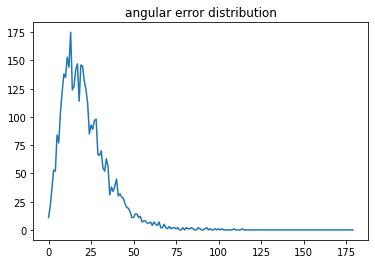

0.8795574618736384


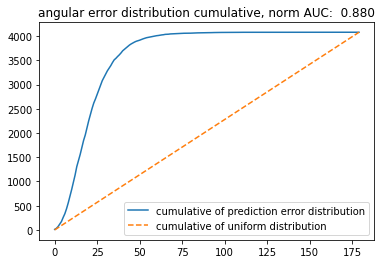

In [14]:
import matplotlib.pyplot as plt

plot_dir = os.path.join(save_path, "plots")
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

plt.title("angular error distribution")
values, bins = np.histogram(angular_errors, bins=180, range = [0, 180])
plt.plot(bins[:-1],values)
plt.savefig(os.path.join(plot_dir,"angular_error_distribution.jpg"), bbox_inches="tight", dpi=600)
plt.show()
plt.close()

# cumulative distribution
values, bins = np.histogram(angular_errors, bins=180, range = [0, 180])
cumul = np.cumsum(values)
tot_sum = np.sum(cumul) / (len(angular_errors) * 180.0)
print(tot_sum)

plt.title("angular error distribution cumulative, norm AUC: {:6.3f}".format(tot_sum))

plt.plot(bins[:-1], cumul, label="cumulative of prediction error distribution")
plt.plot(bins[:-1], np.linspace(0, len(angular_errors), num=len(bins[:-1])), '--', label="cumulative of uniform distribution")
plt.legend()

plt.savefig(os.path.join(plot_dir,"angular_error_distribution_cumulative.jpg"), bbox_inches="tight", dpi=600)
plt.show()
plt.close()